In [372]:
import pandas as pd
import numpy as np 

from datetime import datetime, date, time
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly, plot_cross_validation_metric
import holidays 
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# set float display default
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [50]:
df=pd.read_csv('combined_data.csv')

In [51]:
df['BusinessDate']=pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)

In [52]:
df

,BranchID,CashOrdersReceived,CashBalance_StartOfDay,TotalCashUsed,CashToVault,CashUnder,CashOver,TotalCashDisbursed,TotalCashOpeningBalance,TotalCashReceivedAllSources,HolidayDate,Holiday,before,before_holiday,after,after_holiday,Year,Month,Day_name
BusinessDate,,,,,,,,,,,,,,,,,,,
2010-01-01,99,nan,1195235.33,48082.66,nan,nan,nan,nan,1195235.33,nan,2010-01-01,New Year's Day,NaN,NaN,NaN,NaN,2010,1,Friday
2010-01-02,99,nan,1147152.68,nan,nan,nan,nan,nan,1147152.68,nan,NaN,NaN,NaN,NaN,2010-01-02,New Year's Day_After,2010,1,Saturday
2010-01-03,99,nan,1147152.68,92262.26,nan,nan,nan,nan,1147152.68,nan,NaN,NaN,NaN,NaN,NaN,NaN,2010,1,Sunday
2010-01-04,99,nan,1054890.42,64107.06,nan,nan,nan,nan,1054890.42,nan,NaN,NaN,NaN,NaN,NaN,NaN,2010,1,Monday
2010-01-05,99,nan,990783.35,12372.77,nan,nan,nan,nan,990783.35,nan,NaN,NaN,NaN,NaN,NaN,NaN,2010,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,501,nan,1174197.12,18095.32,nan,nan,nan,nan,1174197.12,nan,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,Monday
2020-07-28,501,nan,1156101.79,161573.86,nan,nan,nan,nan,1156101.79,nan,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,Tuesday
2020-07-29,501,440550.11,1435078.04,66574.28,nan,nan,nan,nan,1435078.04,nan,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,Wednesday


## Seasonal Naive Method (original approach- benchmark)


In [130]:
## prepare past year prediction data
my_df = df[['BranchID', 'TotalCashUsed']].copy()
my_df.reset_index(inplace=True)
### some dates are not included in the original dataset
all_date = pd.DataFrame(pd.date_range('2010-01-01', '2020-07-31'))
all_date.columns = ['ds']

#define BranchIDs
BranchIDs=df['BranchID'].unique()

date_df = pd.DataFrame()
for i in BranchIDs:
    all_date['BranchID'] = i
    date_df=date_df.append(all_date, ignore_index=True)

my_df.shape

(171230, 3)

In [132]:
### merge the full dataset with forecast dataset
merge_df= pd.merge(date_df, my_df, left_on=['ds','BranchID'], right_on=['BusinessDate', 'BranchID'], how='left')
merge_df.fillna(0, inplace=True)
merge_df['ds'] = pd.to_datetime(merge_df['ds'])

print(merge_df.shape)
merge_df.head()

(189385, 4)


,ds,BranchID,BusinessDate,TotalCashUsed
0,2010-01-01,99,2010-01-01 00:00:00,48082.66
1,2010-01-02,99,2010-01-02 00:00:00,0.00
2,2010-01-03,99,2010-01-03 00:00:00,92262.26
3,2010-01-04,99,2010-01-04 00:00:00,64107.06
4,2010-01-05,99,2010-01-05 00:00:00,12372.77


In [133]:
actual_df = merge_df[['ds', 'BranchID', 'TotalCashUsed']].loc[(merge_df['ds'] >= pd.to_datetime('2011-01-01'))]
actual_df.columns=['ds', 'BranchID','y']
forecast_df = merge_df[['ds', 'BranchID', 'TotalCashUsed']]
forecast_df['ds']=forecast_df['ds'] + pd.offsets.DateOffset(years=1)
forecast_df.columns=['ds','BranchID','yhat']

pastyear_df = pd.merge(forecast_df, actual_df, left_on=['BranchID', 'ds'], right_on=['BranchID', 'ds'], how='left')
pastyear_df.set_index('ds', inplace=True)
#THIS IS THE PAST YEAR ESTIMATIONS FOR ALL BRANCHES UNIL 2021-07-31
pastyear_df

<ipython-input-133-f56c2e437d73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['ds']=forecast_df['ds'] + pd.offsets.DateOffset(years=1)


,BranchID,yhat,y
ds,,,
2011-01-01,99,48082.66,0.00
2011-01-02,99,0.00,6626.34
2011-01-03,99,92262.26,60277.63
2011-01-04,99,64107.06,11209.64
2011-01-05,99,12372.77,71478.71
...,...,...,...
2021-07-27,501,18095.32,nan
2021-07-28,501,161573.86,nan
2021-07-29,501,66574.28,nan


In [136]:
# Defind SMAPE function
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


In [138]:
#later we will split training and testing data by 2020-5-20
#calculate overall smape and smape by branch between 2020-5-20 to 2020-7-31
test_df = pastyear_df['2020-5-20':'2020-07-31']

In [139]:
#overall smape
smape(test_df['y'], test_df['yhat'])

141.2648557483911

In [140]:
#smape for each branch
smape_list = {}
for i in BranchIDs: 
    data = test_df[test_df['BranchID']==i]
    smape_list[i]=smape(data['y'], data['yhat'])
smape_list

{99: 119.06158089537739,
 108: 119.35598292086726,
 110: 165.4904784177053,
 111: 160.3125216913272,
 115: 121.17391486855735,
 118: 128.77304505738948,
 125: 122.39881512469074,
 126: 158.1775866260908,
 131: 147.0617145193266,
 133: 142.056083410168,
 140: 134.9502971567454,
 144: 157.42890706146665,
 151: 170.23726652443335,
 154: 125.92987045189147,
 155: 128.72531102739973,
 169: 156.24928331067713,
 177: 176.03463208030297,
 196: 141.37163356357,
 203: 118.76457130950371,
 217: 146.4401528458792,
 230: 128.65342199234234,
 267: 154.58426091333763,
 270: 107.51979548483956,
 273: 152.06640603902207,
 289: 120.62380314288005,
 290: 146.76421100996828,
 317: 133.1744545350229,
 319: 139.72602739726025,
 323: 161.81529782748729,
 325: 151.64159243660788,
 333: 173.50945717421146,
 334: 143.66097438189848,
 336: 117.22219072150185,
 344: 162.1029825961832,
 356: 148.1788889049663,
 362: 133.892599393417,
 364: 149.02410837239475,
 367: 164.67446318057614,
 370: 144.88465507150056,
 38

In [211]:
#plot branch 270
past_270=test_df[test_df['BranchID']==270]

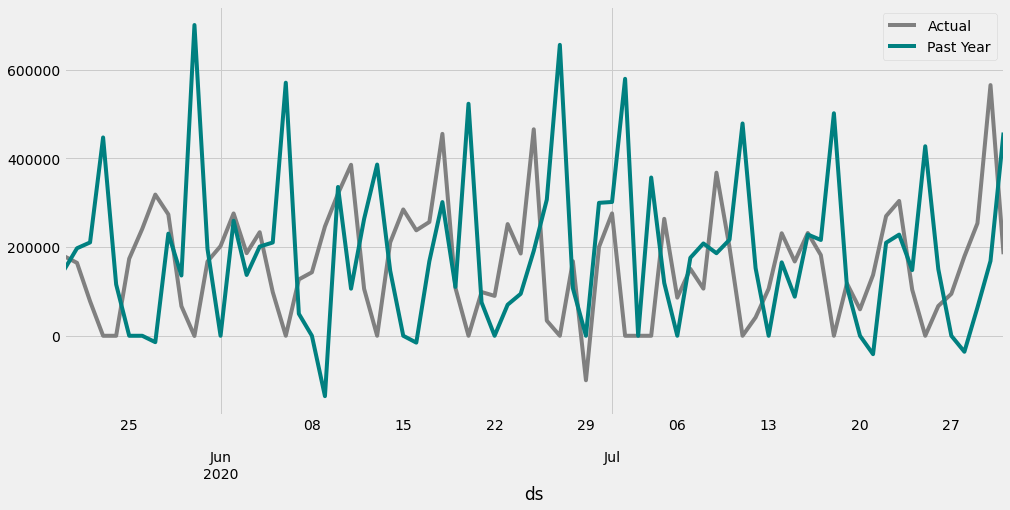

In [387]:
fig, ax = plt.subplots(figsize=(15,7))
ax=past_270['y'].plot(label='Actual', legend=True, color='gray')
ax=past_270['yhat'].plot(label='Past Year', legend=True, color='teal')
plt.show()

# ACF and PACF

In [53]:
# choose branch 270 to show an example
mask = df['BranchID'] == 270 
df_270 = df[mask]


In [54]:
df_270.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3837 entries, 2010-01-01 to 2020-07-31
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BranchID                     3837 non-null   int64  
 1   CashOrdersReceived           552 non-null    float64
 2   CashBalance_StartOfDay       3837 non-null   float64
 3   TotalCashUsed                3208 non-null   float64
 4   CashToVault                  0 non-null      float64
 5   CashUnder                    7 non-null      float64
 6   CashOver                     15 non-null     float64
 7   TotalCashDisbursed           31 non-null     float64
 8   TotalCashOpeningBalance      3837 non-null   float64
 9   TotalCashReceivedAllSources  31 non-null     float64
 10  HolidayDate                  122 non-null    object 
 11  Holiday                      122 non-null    object 
 12  before                       126 non-null    object 
 13  

In [55]:
cash270 = df_270[['TotalCashUsed']].fillna(0)
cash270

,TotalCashUsed
BusinessDate,
2010-01-01,45524.58
2010-01-02,0.00
2010-01-03,227296.81
2010-01-04,212833.84
2010-01-05,303769.32
...,...
2020-07-27,94572.48
2020-07-28,179025.11
2020-07-29,253736.78


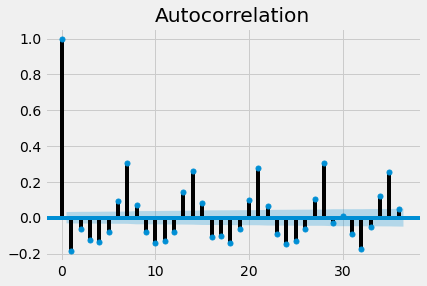

In [377]:
plot_acf(cash270)
plt.show()

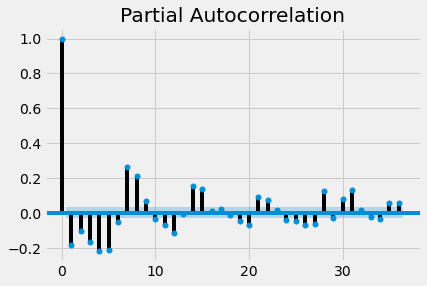

In [378]:
plot_pacf(cash270)
plt.show()

In [380]:
res = seasonal_decompose(x=cash270['TotalCashUsed'], period=365)

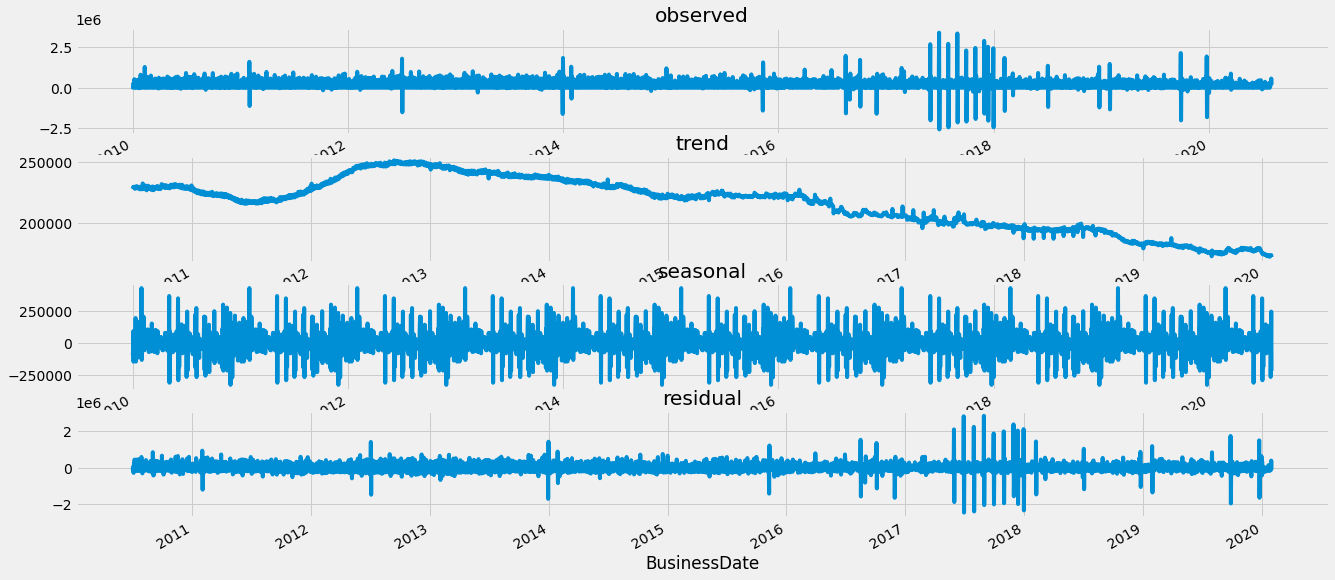

In [381]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,10))
res.observed.plot(ax=ax1, title="observed")
res.trend.plot(ax=ax2, title="trend")
res.seasonal.plot(ax=ax3, title="seasonal")
res.resid.plot(ax=ax4, title="residual")

In [98]:
#function for ADF test
def adf_test(y):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['test statistic', 'p-value', '# of lags','# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [99]:
adf_test(cash270['TotalCashUsed'])

Results of Augmented Dickey-Fuller test:
test statistic           -8.01
p-value                   0.00
# of lags                30.00
# of observations      3806.00
Critical Value (1%)      -3.43
Critical Value (5%)      -2.86
Critical Value (10%)     -2.57
dtype: float64


## Basic ARIMA

In [121]:
model = ARIMA(cash270, order=(6,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\hz2cp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\hz2cp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:        D.TotalCashUsed   No. Observations:                 3836
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -53545.411
Method:                       css-mle   S.D. of innovations         279098.438
Date:                Wed, 03 Mar 2021   AIC                         107106.822
Time:                        15:40:02   BIC                         107156.839
Sample:                             1   HQIC                        107124.590
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    36.0873    738.827      0.049      0.961   -1411.988    1484.162
ar.L1.D.TotalCashUsed    -1.0893      0.014    -76.678      0.000      -1.117      -1.061
ar.L2.D.

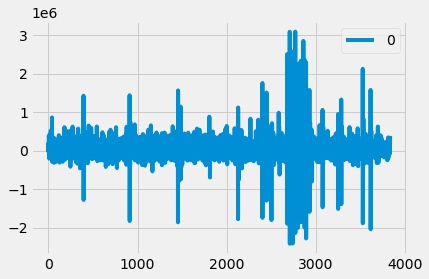

In [382]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# here may still be some trend information not caputured by the model

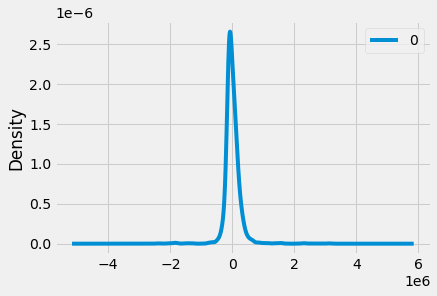

                0
count     3835.00
mean      -648.66
std     279197.10
min   -2416155.40
25%    -113515.24
50%     -29131.98
75%      94403.71
max    3091856.65


In [383]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Auto Arima

In [125]:
stepwise_model = auto_arima(cash270, start_p=1, start_q=1, 
                           max_p = 6, max_q = 6, m =12, 
                           start_P = 0, seasonal = True, 
                           d=1, D=1, trace = True, 
                           error_action='ignore',
                           suppress_warnings = True,
                           stepwise=True)
## account for seasonality: SARIMA

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=11.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=113328.399, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=111120.828, Time=1.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=112090.823, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=110632.706, Time=3.98 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.69 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=111620.431, Time=2.37 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=110120.512, Time=5.99 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=110822.120, Time=2.52 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=16.53 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=109758.405, Time=7.60 sec
 ARIMA(3,1,0)(1,1,0)[12]      

In [126]:
print(stepwise_model.aic())

108016.78201646009


### Split test and train

In [252]:
X = cash270.TotalCashUsed
train = X[:'2020-05-19']
test = X['2020-05-20':]

In [170]:
history=[x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order = (6,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected =%f' % (yhat, obs))
    

predicted=175380.937980, expected =179751.250000
predicted=129692.784334, expected =164481.310000
predicted=96923.759981, expected =78001.180000
predicted=102124.117945, expected =0.000000
predicted=173704.152797, expected =0.000000
predicted=141892.395349, expected =173829.610000
predicted=161677.919510, expected =241145.710000
predicted=137007.314020, expected =318429.390000
predicted=109760.043684, expected =273729.300000
predicted=71018.190367, expected =66892.520000
predicted=74057.598854, expected =-440.110000
predicted=117693.159143, expected =167600.290000
predicted=187978.479976, expected =202273.720000
predicted=236672.830359, expected =275912.200000
predicted=246442.943287, expected =186316.370000
predicted=183763.436551, expected =233581.340000
predicted=76451.120523, expected =98607.450000
predicted=110845.001750, expected =0.000000
predicted=202556.895388, expected =127086.240000
predicted=202951.608992, expected =143195.270000
predicted=213114.577490, expected =246488.49

In [253]:
test = pd.DataFrame(test)

In [254]:
test['yhat'] = np.array(predictions)

In [255]:
test

,TotalCashUsed,yhat
BusinessDate,,
2020-05-20,179751.25,175380.94
2020-05-21,164481.31,129692.78
2020-05-22,78001.18,96923.76
2020-05-23,0.00,102124.12
2020-05-24,0.00,173704.15
...,...,...
2020-07-27,94572.48,111637.65
2020-07-28,179025.11,177411.72
2020-07-29,253736.78,226351.21


In [256]:
#calculate smape for branch 270
smape(test['TotalCashUsed'], test['yhat'])

75.08809706666935

### Train auto arima model

In [257]:
train_a = cash270.loc[: '2020-05-19']
test_a = cash270.loc['2020-05-20':]

In [258]:
stepwise_model.fit(train_a)

ARIMA(order=(6, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [259]:
future_forecast = stepwise_model.predict(n_periods=len(test_a))

In [260]:
future_forecast = pd.DataFrame(future_forecast, index=test_a.index, columns=['Prediction'])

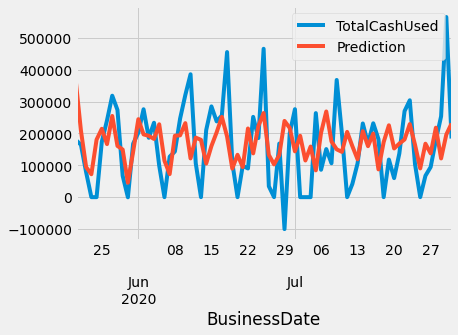

In [384]:
pd.concat([test_a, future_forecast], axis = 1).plot()

In [262]:
aa_df = pd.concat([test_a, future_forecast], axis=1)
aa_df

,TotalCashUsed,Prediction
BusinessDate,,
2020-05-20,179751.25,367363.75
2020-05-21,164481.31,209179.91
2020-05-22,78001.18,94238.51
2020-05-23,0.00,71933.11
2020-05-24,0.00,180548.02
...,...,...
2020-07-27,94572.48,137251.06
2020-07-28,179025.11,217971.64
2020-07-29,253736.78,121529.58


In [263]:
smape(aa_df['TotalCashUsed'], aa_df['Prediction'])

75.61966658391302

It was not as good as the Arima model.

<ipython-input-386-d85da12df03b>:10: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



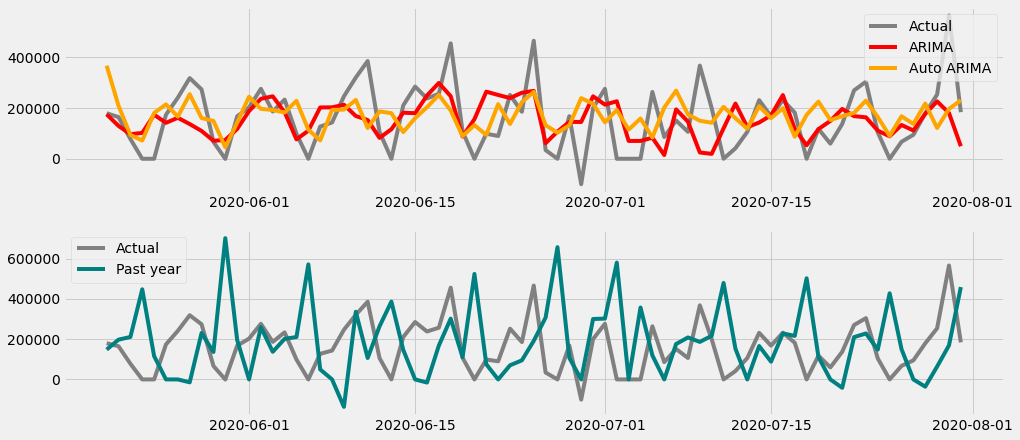

In [386]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,7))

axes[0].plot(test.index, 'TotalCashUsed', data = test, label='Actual', color='gray')
axes[0].plot(test.index, 'yhat', data=test, label='ARIMA', color='red')
axes[0].plot(aa_df.index, 'Prediction', data=aa_df, label='Auto ARIMA', color='orange')
axes[0].set_title('')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].legend()

axes[1].plot(past_270.index, 'y', data = past_270, label='Actual', color='gray')
axes[1].plot(past_270.index, 'yhat', data = past_270, label='Past year', color='teal')
axes[1].set_title('')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].legend()

plt.show()

# Use prophet to predict

## find zero-cash days

In [267]:
# Find zero cash days by branch
# cannot fill original df, it will influence the model. Make a copy of the data and fill na with zero
mydata = df.copy()
mydata['CashBalance_StartOfDay'].fillna(0, inplace = True)
mydata ['CashOrdersReceived'].fillna(0, inplace=True)
mydata ['TotalCashUsed'].fillna(0, inplace=True)

## find weekdays with zeros by branch from 2018 to 2020
df_zero = mydata[mydata['TotalCashUsed']==0]
zero_count = df_zero['2018':'2020'].groupby(['BranchID', 'Day_name'])[['TotalCashUsed']].count()
total_count = mydata['2018':'2020'].groupby(['BranchID', 'Day_name'])[['TotalCashUsed']].count()
percent_zero = zero_count/total_count
mask =percent_zero['TotalCashUsed']> 0.9
zero_list = percent_zero[mask].reset_index()

zero_dict=dict()
for index, row in zero_list.iterrows():
    if row['Day_name'] in zero_dict.keys():
        zero_dict[row['Day_name']].append(row['BranchID'])
    else:
        zero_dict[row['Day_name']]= [row['BranchID']]

# Find Zero Cash holidays by branch from 2015 to 2020
df_zero = mydata[mydata['TotalCashUsed']==0]
zero_count = df_zero['2015':'2020'].groupby(['BranchID', 'Holiday'])[['TotalCashUsed']].count()
total_count = mydata['2015':'2020'].groupby(['BranchID', 'Holiday'])[['TotalCashUsed']].count()
percent_zero = zero_count/total_count
mask =percent_zero['TotalCashUsed']> 0.9
zero_list = percent_zero[mask].reset_index()

zero_holiday_dict=dict()
for index, row in zero_list.iterrows():
    if row['Holiday'] in zero_holiday_dict.keys():
        zero_holiday_dict[row['Holiday']].append(row['BranchID'])
    else:
        zero_holiday_dict[row['Holiday']]= [row['BranchID']]

# zero cash before holiday day
df_zero = mydata[mydata['TotalCashUsed']==0]
zero_count = df_zero['2015':'2020'].groupby(['BranchID', 'before_holiday'])[['TotalCashUsed']].count()
total_count = mydata['2015':'2020'].groupby(['BranchID', 'before_holiday'])[['TotalCashUsed']].count()
percent_zero = zero_count/total_count
mask =percent_zero['TotalCashUsed']> 0.9
zero_list = percent_zero[mask].reset_index()

zero_before_holiday_dict=dict()
for index, row in zero_list.iterrows():
    if row['before_holiday'] in zero_before_holiday_dict.keys():
        zero_before_holiday_dict[row['before_holiday']].append(row['BranchID'])
    else:
        zero_before_holiday_dict[row['before_holiday']]= [row['BranchID']]

# zero cash after holiday day
df_zero = mydata[mydata['TotalCashUsed']==0]
zero_count = df_zero['2015':'2020'].groupby(['BranchID', 'after_holiday'])[['TotalCashUsed']].count()
total_count = mydata['2015':'2020'].groupby(['BranchID', 'after_holiday'])[['TotalCashUsed']].count()
percent_zero = zero_count/total_count
mask = percent_zero['TotalCashUsed']> 0.9
zero_list = percent_zero[mask].reset_index()

zero_after_holiday_dict=dict()
for index, row in zero_list.iterrows():
    if row['after_holiday'] in zero_after_holiday_dict.keys():
        zero_after_holiday_dict[row['after_holiday']].append(row['BranchID'])
    else:
        zero_after_holiday_dict[row['after_holiday']]= [row['BranchID']]

## Prepare data for Prophet

In [268]:
BranchIDs= df['BranchID'].unique()
BranchIDs

array([ 99, 108, 110, 111, 115, 118, 125, 126, 131, 133, 140, 144, 151,
       154, 155, 169, 177, 196, 203, 217, 230, 267, 270, 273, 289, 290,
       317, 319, 323, 325, 333, 334, 336, 344, 356, 362, 364, 367, 370,
       382, 398, 415, 425, 433, 434, 441, 458, 469, 501], dtype=int64)

### Add holiday effect

In [269]:
holiday = pd.read_csv('full_holidays.csv')
holiday = holiday[['Holiday', 'HolidayDate']]
holiday.head()

,Holiday,HolidayDate
0,Christmas Day,2020-12-25
1,Christmas Eve,2020-12-24
2,Day After T-Day (TCU only),2020-11-27
3,Thanksgiving,2020-11-26
4,Veterans Day,2020-11-11


In [270]:
holiday.columns = ['holiday', 'ds']
holiday.sort_values(['ds'], ignore_index = True, inplace=True)
holiday['ds'] = pd.to_datetime(holiday['ds'])

In [271]:
# adjust the lower window based on the dictionary before
holiday['lower_window'] = 0
holiday['upper_window'] = 0
holiday['lower_window'].loc[holiday['holiday'] == 'Christmas Day'] = -1
holiday['lower_window'].loc[holiday['holiday'] == 'Christmas Day (Observed)'] = -1
holiday['lower_window'].loc[holiday['holiday'] == 'Christmas Eve'] = -1
holiday['lower_window'].loc[holiday['holiday'] == 'Independence Day'] = -1
holiday['lower_window'].loc[holiday['holiday'] == 'Independence Day (Observed)'] = -1
holiday['lower_window'].loc[holiday['holiday'] == "New Year's Day"] = -1
holiday['lower_window'].loc[holiday['holiday'] == "New Year's Day (Observed)"] = -1
holiday['lower_window'].loc[holiday['holiday'] == 'Thanksgiving'] = -1

C:\Users\hz2cp\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [272]:
#add before and after holidays
before_holidays = pd.DataFrame()
after_holidays = pd.DataFrame()

before_holidays['before'] = holiday['ds']-timedelta(days=1)
before_holidays['before_holiday'] = holiday['holiday'] + '_Before'
after_holidays['after'] = holiday['ds'] + timedelta(days=1)
after_holidays['after_holiday'] = holiday['holiday'] + '_After'

In [273]:
before_holidays

,before,before_holiday
0,2009-12-31,New Year's Day_Before
1,2010-01-17,Martin Luther King Jr. Day_Before
2,2010-02-14,Washington's Birthday_Before
3,2010-04-01,Good Friday (half day)_Before
4,2010-05-30,Memorial Day_Before
...,...,...
145,2021-11-10,Veterans Day_Before
146,2021-11-24,Thanksgiving_Before
147,2021-12-23,Christmas Day (Observed)_Before
148,2021-12-24,Christmas Day_Before


### Additional regressors

In [274]:
# define COVID time function, end time is set to 2021-12-31 for now.
def is_covid_time(ds):
    """
    Function to find whether it is covid time or not

    """
    date = pd.to_datetime(ds)
    return date >= pd.to_datetime('2020-03-20') and date <= pd.to_datetime('2021-12-31')


In [275]:
# define weekends function 

## weekend function
def is_weekends(ds):
    date = pd.to_datetime(ds)
    if date.day_name() == 'Saturday' or date.day_name() == 'Sunday':
        result=1
    else:
        result=0
    return result

## Fit the model

### fit one branch

In [414]:
#select branch
id=99
mask = df['BranchID'] == id
data = df[mask]
data = data.reset_index()[['BusinessDate','TotalCashUsed']]

#rename column
data.rename(columns={'BusinessDate': 'ds', 'TotalCashUsed': 'y'}, inplace=True)

#find cash order received date
#mask2 = data['CashOrdersReceived'] !=0 
#orderday = data[mask2].groupby(['Day_name'])['CashOrdersReceived'].count().idxmax()

#split train and test data (include COVID time in training data)
train_ts = data.loc[lambda df: df['ds'] <pd.to_datetime('2020-05-20'), :] 
test_ts = data.loc[lambda df: df['ds'] >= pd.to_datetime('2020-05-20'), :] 

#fill the outliers of training data with 7day rolling mean
train_ts['rollingmean'] = train_ts.y.rolling(window=7, min_periods=1).mean()
std_mult = 3
mask2 = np.abs(train_ts.y-train_ts.y.mean() >= std_mult*train_ts.y.std())
train_ts.loc[mask2, 'y'] = train_ts.loc[mask2, 'rollingmean']
train_ts = train_ts[['ds', 'y']]

#add additional regressors
train_ts['is_covid'] = train_ts['ds'].apply(is_covid_time)
train_ts['not_covid'] = ~train_ts['ds'].apply(is_covid_time)
#train_ts['is_weekends'] = train_ts['ds'].apply(is_weekends)



#fit the model
m = Prophet(holidays=holiday, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=True, seasonality_mode='multiplicative', 
       changepoint_prior_scale=0.1, seasonality_prior_scale=0.1, holidays_prior_scale=10 )
m.add_seasonality(name='weekly_is_covid', period=7, fourier_order=3, condition_name='is_covid')
m.add_seasonality(name='weekly_not_covid', period=7, fourier_order=3, condition_name='not_covid')
#m.add_seasonality(name='monthly', period=30.5, fourier_order=4)
#m.add_regressor('is_weekends')


m.fit(train_ts)

#make future dataframe
future = m.make_future_dataframe(periods=len(test_ts)) 

future['is_covid'] = future['ds'].apply(is_covid_time)
future['not_covid'] = ~future['ds'].apply(is_covid_time)
#future['is_weekends'] = future['ds'].apply(is_weekends)

#predict future values
forecast = m.predict(future)

smape_res = smape(test_ts['y'], forecast['yhat'])
print('smape before taking consideration of closing days:', smape_res)


<ipython-input-414-735c4e3feebe>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hz2cp\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



smape before taking consideration of closing days: 47.375352013297395


## plot the model

In [407]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly_not_covid,weekly_not_covid_lower,weekly_not_covid_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-01,1685611.96,-66555.46,439151.22,1685611.96,1685611.96,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,189173.69
1,2010-01-02,1685645.33,-467086.17,19988.81,1685645.33,1685645.33,0.00,0.00,0.00,0.00,...,-0.25,-0.25,-0.25,-0.01,-0.01,-0.01,0.00,0.00,0.00,-226595.91
2,2010-01-03,1685678.70,-159384.64,345532.24,1685678.70,1685678.70,0.00,0.00,0.00,0.00,...,-0.06,-0.06,-0.06,-0.01,-0.01,-0.01,0.00,0.00,0.00,83561.56
3,2010-01-04,1685712.06,-100183.59,408595.25,1685712.06,1685712.06,0.00,0.00,0.00,0.00,...,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,0.00,0.00,0.00,146182.94
4,2010-01-05,1685745.43,-22110.02,466955.12,1685745.43,1685745.43,0.00,0.00,0.00,0.00,...,0.04,0.04,0.04,-0.02,-0.02,-0.02,0.00,0.00,0.00,225300.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,2020-07-27,1261961.84,-109138.08,388760.18,1261625.94,1262213.15,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,148639.79
3833,2020-07-28,1261883.83,-33744.74,458946.18,1261552.03,1262146.55,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,208502.20
3834,2020-07-29,1261805.82,-38308.20,481964.11,1261465.80,1262087.09,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,224759.39
3835,2020-07-30,1261727.82,-12988.70,487354.81,1261375.96,1262027.60,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,229159.19


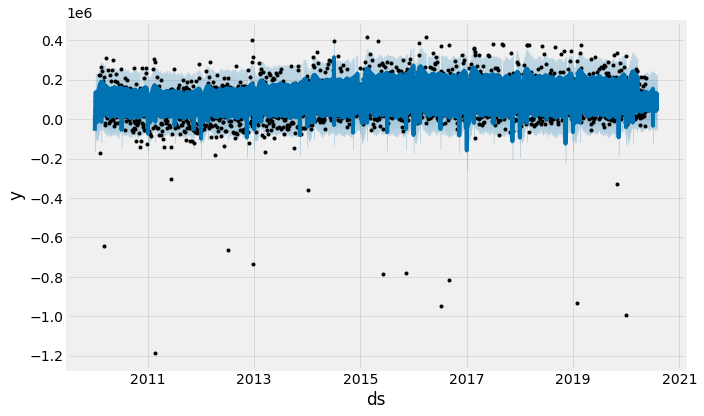

In [415]:
m.plot(forecast);

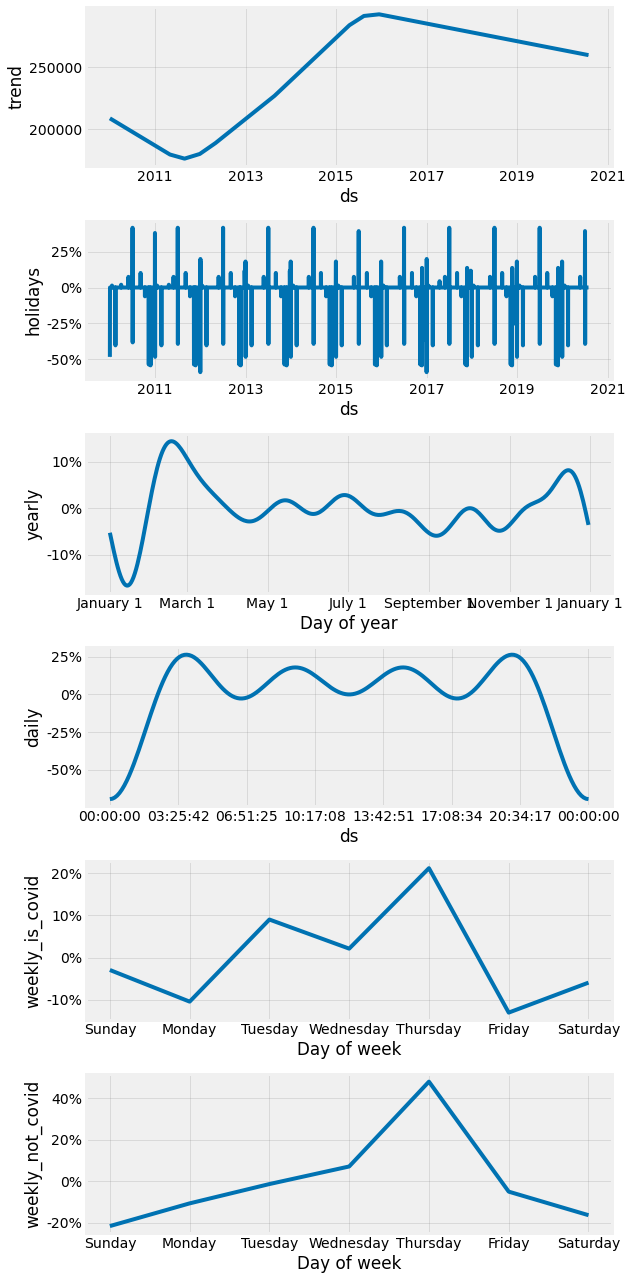

In [416]:
m.plot_components(forecast);


## Consider the closing dates

In [355]:
#set close date to zeros in forecast data based on zero_dict
forecast['Day_name']= forecast['ds'].dt.day_name()
forecast['yhat_2']=forecast['yhat']

#forecast['yhat'][forecast['Day_name']== 'Saturday'] = 0
for key in zero_dict.keys():
    if id in zero_dict[key]:
        forecast['yhat_2'][forecast['Day_name']== key] = 0


#set certain branche's Holiday and day before and day after to zero based on zero holiday dict
forecast = pd.merge(forecast, holiday, left_on='ds', right_on='ds', how='left')
forecast = pd.merge(forecast, before_holidays, left_on='ds', right_on='before', how='left')
forecast = pd.merge(forecast, after_holidays, left_on='ds', right_on='after', how='left')
for key in zero_holiday_dict.keys():
    if id in zero_holiday_dict[key]:
        forecast['yhat_2'][forecast['holiday']== key] = 0
for key in zero_before_holiday_dict.keys():
    if id in zero_before_holiday_dict[key]:
        forecast['yhat_2'][forecast['before_holiday']== key] = 0 
for key in zero_after_holiday_dict.keys():
    if id in zero_after_holiday_dict[key]:
        forecast['yhat_2'][forecast['after_holiday']== key] = 0


#merge original data with forecast
forecast = pd.merge(forecast, data, how='left',
    left_on='ds', right_on='ds')
forecast['BranchID'] = id

#calculate SMAPE for each branch
a = forecast['y']
f = forecast['yhat_2']
smape_res2 = smape(a, f)
print('smape after taking consideration of closing days:', smape_res2)

smape after taking consideration of closing days: 34.561554639438796


<ipython-input-355-b641bf8d613e>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-355-b641bf8d613e>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-355-b641bf8d613e>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-355-b641bf8d613e>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

## Compare with seasonal naive predicition

In [356]:
# compare the actual with fb and pastyear predictions
#select the past year data for only the Branch chosen before
mask = pastyear_df['BranchID'] == id
pastyear= pastyear_df[mask]

In [390]:
ds = forecast['ds']
FBPrediction = forecast['yhat_2']
Actual = forecast['y']
PastyearPrediction = pastyear['yhat']
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=ds, y=Actual, name='Actual', opacity=.7,
                         line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=ds, y=FBPrediction, name='Prophet Prediction', opacity=.5,
                         line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=ds, y=PastyearPrediction, name='Paster Year', opacity=.4,
                         line=dict(color='green', width=2)))
fig.update_layout(
    autosize=False,
    width=1280,
    height=450,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=1
    )
)

In [365]:
timeframe=forecast['ds'] >= pd.to_datetime('2020-05-20')
prophet_df = forecast[timeframe]
prophet_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,yhat_2,holiday,lower_window,upper_window,before,before_holiday,after,after_holiday,y,BranchID
3764,2020-05-20,1267266.19,-20924.21,489885.29,1267266.19,1267266.19,0.00,0.00,0.00,0.00,...,225694.51,NaN,nan,nan,NaT,NaN,NaT,NaN,179751.25,270
3765,2020-05-21,1267188.18,-11748.52,487078.75,1267188.18,1267188.18,0.00,0.00,0.00,0.00,...,229763.59,NaN,nan,nan,NaT,NaN,NaT,NaN,164481.31,270
3766,2020-05-22,1267110.18,-144523.28,332087.84,1267110.18,1267110.18,0.00,0.00,0.00,0.00,...,93913.89,NaN,nan,nan,NaT,NaN,NaT,NaN,78001.18,270
3767,2020-05-23,1267032.17,-228942.38,306211.94,1267032.17,1267032.17,0.00,0.00,0.00,0.00,...,0.00,NaN,nan,nan,NaT,NaN,NaT,NaN,nan,270
3768,2020-05-24,1266954.17,-124423.50,391840.91,1266954.17,1266954.17,0.00,0.00,0.00,0.00,...,0.00,NaN,nan,nan,2020-05-24,Memorial Day_Before,NaT,NaN,nan,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,2020-07-27,1261961.84,-111075.48,392982.57,1261652.36,1262286.43,0.00,0.00,0.00,0.00,...,148639.79,NaN,nan,nan,NaT,NaN,NaT,NaN,94572.48,270
3833,2020-07-28,1261883.83,-39399.94,450550.67,1261543.10,1262213.81,0.00,0.00,0.00,0.00,...,208502.20,NaN,nan,nan,NaT,NaN,NaT,NaN,179025.11,270
3834,2020-07-29,1261805.82,-28649.69,454386.77,1261453.66,1262141.52,0.00,0.00,0.00,0.00,...,224759.39,NaN,nan,nan,NaT,NaN,NaT,NaN,253736.78,270
3835,2020-07-30,1261727.82,-17623.30,465893.06,1261352.90,1262069.16,0.00,0.00,0.00,0.00,...,229159.19,NaN,nan,nan,NaT,NaN,NaT,NaN,565402.08,270


<ipython-input-401-ee66832f0e5b>:3: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



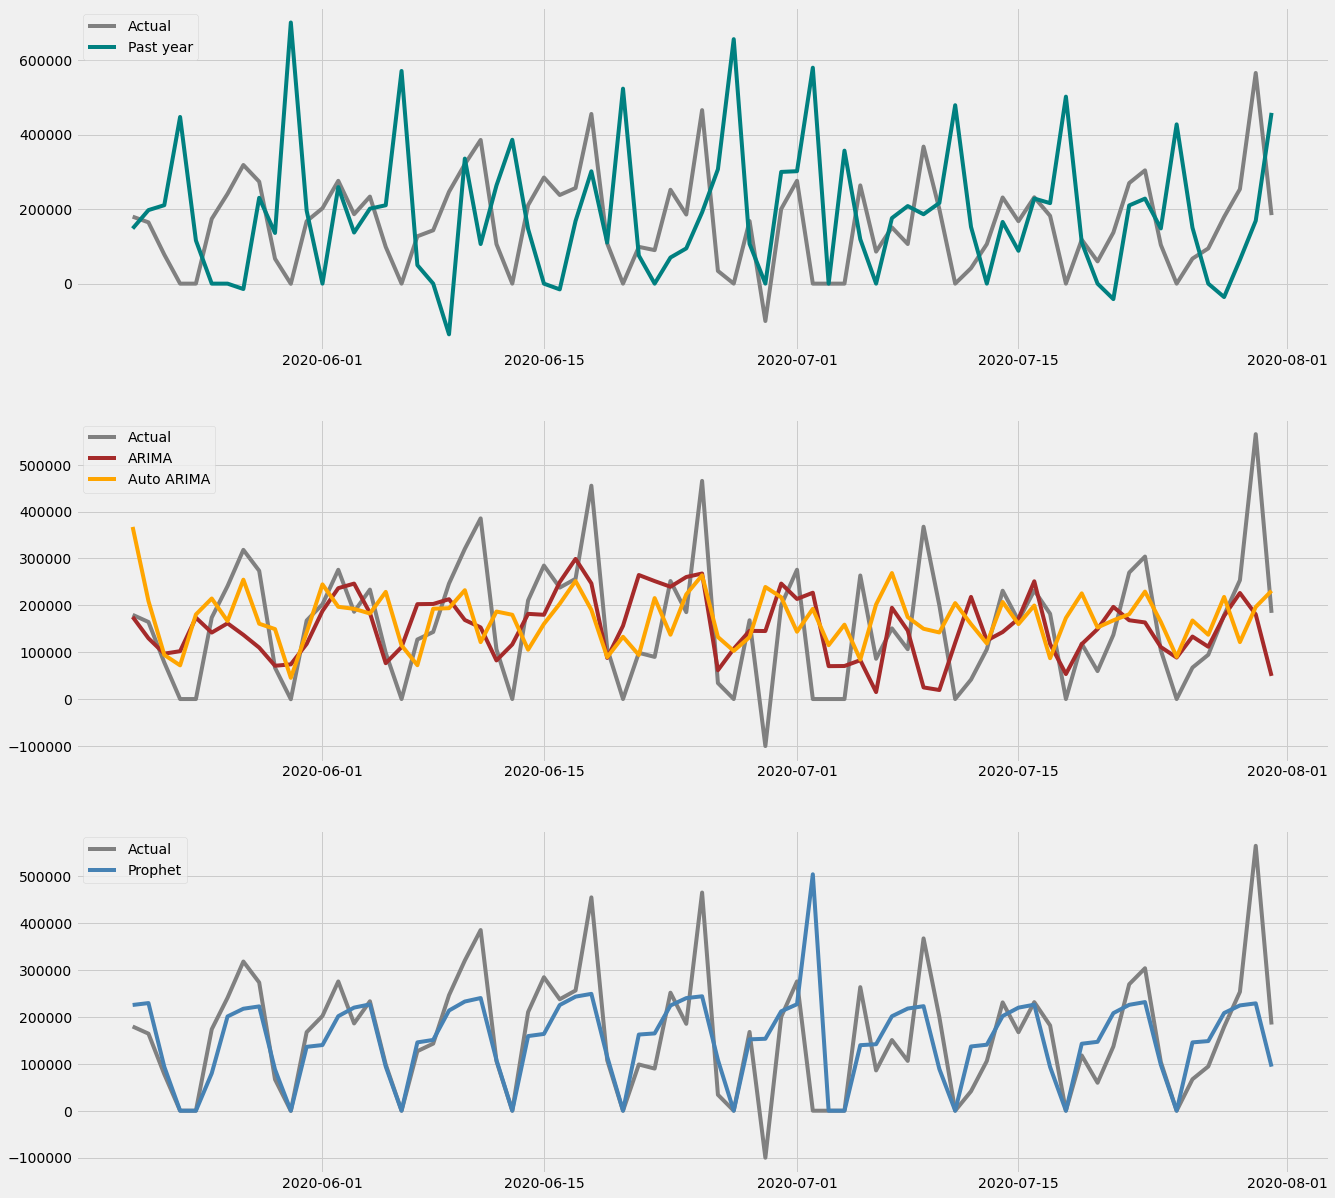

In [401]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

axes[0].plot(past_270.index, 'y', data = past_270, label='Actual', color='gray')
axes[0].plot(past_270.index, 'yhat', data = past_270, label='Past year', color='teal')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].legend(loc="upper left")

axes[1].plot(test.index, 'TotalCashUsed', data = test, label='Actual', color='gray')
axes[1].plot(test.index, 'yhat', data=test, label='ARIMA', color='brown')
axes[1].plot(aa_df.index, 'Prediction', data=aa_df, label='Auto ARIMA', color='orange')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].legend(loc="upper left")

axes[2].plot(test.index, 'TotalCashUsed', data = test, label='Actual', color='gray')
axes[2].plot(prophet_df['ds'], 'yhat_2', data=prophet_df, label='Prophet', color='steelblue')

axes[2].ticklabel_format(style='plain', axis='y')
axes[2].legend(loc="upper left")


plt.show()

In [360]:
past270_week=past_270.reset_index().resample('W', on='ds').sum()
smape(past270_week['y'], past270_week['yhat'])

37.428504325122155

In [361]:
arima270_week=test.reset_index().resample("W", on='BusinessDate').sum()
smape(arima270_week['TotalCashUsed'], arima270_week['yhat'])

25.023295668352194

In [362]:
aa270_week=aa_df.reset_index().resample("W", on='BusinessDate').sum()
smape(aa270_week['TotalCashUsed'], aa270_week['Prediction'])

26.234386536128497

In [367]:
prophet270_week=prophet_df.resample('W', on='ds').sum()
smape(prophet270_week['y'],prophet270_week['yhat_2'])

20.858665215596154

<ipython-input-402-2ddd1b2d3153>:3: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



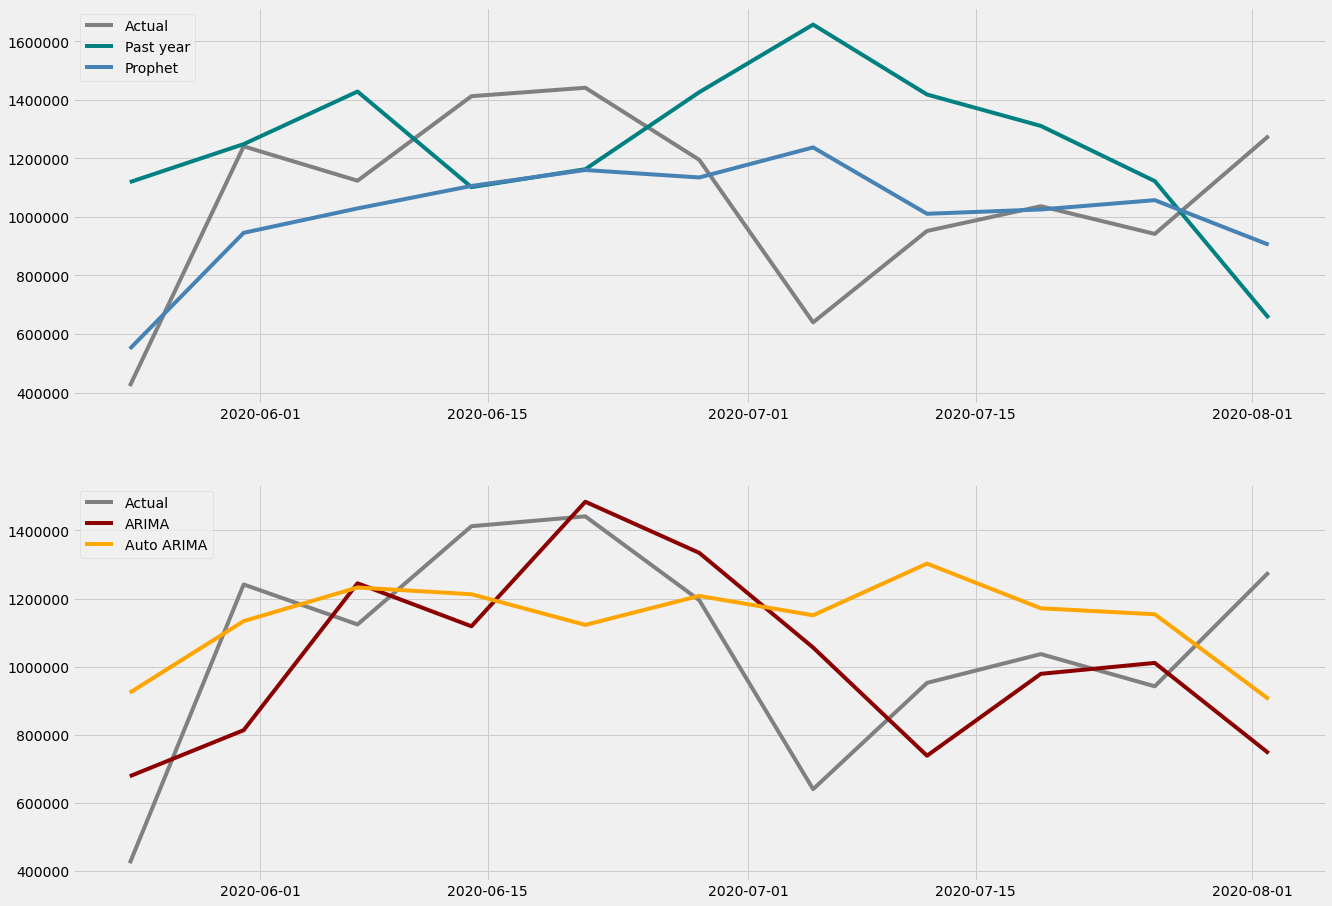

In [402]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))

axes[0].plot(past270_week.index, 'y', data = past270_week, label='Actual', color='gray')
axes[0].plot(past270_week.index, 'yhat', data = past270_week, label='Past year', color='teal')
axes[0].plot(prophet270_week.index, 'yhat_2', data=prophet270_week, label='Prophet', color='steelblue')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].legend(loc="upper left")

axes[1].plot(arima270_week.index, 'TotalCashUsed', data = arima270_week, label='Actual', color='gray')
axes[1].plot(arima270_week.index, 'yhat', data=arima270_week, label='ARIMA', color='darkred')
axes[1].plot(aa270_week.index, 'Prediction', data=aa270_week, label='Auto ARIMA', color='orange')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].legend(loc="upper left")



plt.show()

In [161]:
pastyear_by_week=pastyear.reset_index().resample('W', on='ds').sum()
pastyear_by_week

,BranchID,yhat,y
ds,,,
2011-01-02,540,45524.58,376493.78
2011-01-09,1890,1556184.83,1293126.85
2011-01-16,1890,1086991.99,1187435.22
2011-01-23,1890,1347915.37,1058598.11
2011-01-30,1890,1375981.03,1388114.69
...,...,...,...
2021-07-04,1890,544164.57,0.00
2021-07-11,1890,1174397.59,0.00
2021-07-18,1890,960168.89,0.00


In [169]:
mask1 = (forecast_by_week.index> '2020-5-20') & (forecast_by_week.index<='2020-07-31')
mask2 = (pastyear_by_week.index> '2020-5-20') & (pastyear_by_week.index<='2020-07-31')

plot_forecast = forecast_by_week[mask1].reset_index()
plot_pastyear = pastyear_by_week[mask2].reset_index()

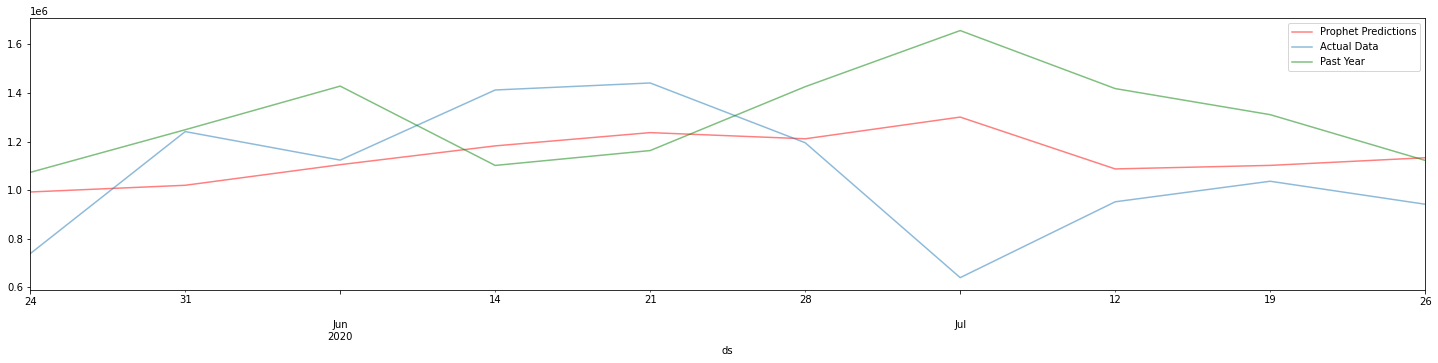

In [171]:
ax=plot_forecast.plot(x='ds', y='yhat', label='Prophet Predictions', color='red', alpha = 0.5, legend=True, figsize=(25,5))
ax=plot_forecast.plot(x='ds', y='y', label='Actual Data', alpha = 0.5, legend=True)
ax=plot_pastyear.plot(x='ds', y='yhat', label='Past Year', alpha = 0.5, legend=True, color='green')


## Loop through all branches

In [330]:
data_all=pd.DataFrame()
smape_before={}
smape_after={}
for id in BranchIDs:
    #select branch
    mask = df['BranchID'] == id
    data = df[mask]
    data = data.reset_index()[['BusinessDate','TotalCashUsed']]
    
    #rename column
    data.rename(columns={'BusinessDate': 'ds', 'TotalCashUsed': 'y'}, inplace=True)
    
    #find cash order received date
    #mask2 = data['CashOrdersReceived'] !=0 
    #orderday = data[mask2].groupby(['Day_name'])['CashOrdersReceived'].count().idxmax()
    
    #split train and test data
    train_ts = data.loc[lambda df: df['ds'] <pd.to_datetime('2020-05-20'), :] 
    test_ts = data.loc[lambda df: df['ds'] >= pd.to_datetime('2020-05-20'), :] 
    
    #fill the outliers of training data with 7day rolling mean
    train_ts['rollingmean'] = train_ts.y.rolling(window=7, min_periods=1).mean()
    std_mult = 3
    mask2 = np.abs(train_ts.y-train_ts.y.mean() >= std_mult*train_ts.y.std())
    train_ts.loc[mask2, 'y'] = train_ts.loc[mask2, 'rollingmean']
    train_ts = train_ts[['ds', 'y']]
     
    #add additional regressors
    train_ts['is_covid'] = train_ts['ds'].apply(is_covid_time)
    train_ts['not_covid'] = ~train_ts['ds'].apply(is_covid_time)
    #train_ts['is_weekends'] = train_ts['ds'].apply(is_weekends)
      
  
   
    #fit the model
    m = Prophet(holidays=holiday, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=True, seasonality_mode='multiplicative', 
           changepoint_prior_scale=0.1, seasonality_prior_scale=0.1, holidays_prior_scale=10 )
    m.add_seasonality(name='weekly_is_covid', period=7, fourier_order=3, condition_name='is_covid')
    m.add_seasonality(name='weekly_not_covid', period=7, fourier_order=3, condition_name='not_covid')
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=4)
    #m.add_regressor('is_weekends')
   
    
    m.fit(train_ts)
    
    #make future dataframe
    future = m.make_future_dataframe(periods=len(test_ts)) 
    
    future['is_covid'] = future['ds'].apply(is_covid_time)
    future['not_covid'] = ~future['ds'].apply(is_covid_time)
    #future['is_weekends'] = future['ds'].apply(is_weekends)
    
    #predict future values
    forecast = m.predict(future)
    
    #smape before taking into consideration the closing date
    smape_before[id] = smape(test_ts['y'], forecast['yhat'])
    
    #set close date to zeros in forecast data based on zero_dict
    forecast['Day_name']= forecast['ds'].dt.day_name()
    #forecast['yhat'][forecast['Day_name']== 'Saturday'] = 0
    for key in zero_dict.keys():
        if id in zero_dict[key]:
            forecast['yhat'][forecast['Day_name']== key] = 0
    
    #set certain branche's Holiday and day before and day after to zero based on zero holiday dict
    forecast = pd.merge(forecast, holiday, left_on='ds', right_on='ds', how='left')
    forecast = pd.merge(forecast, before_holidays, left_on='ds', right_on='before', how='left')
    forecast = pd.merge(forecast, after_holidays, left_on='ds', right_on='after', how='left')
    for key in zero_holiday_dict.keys():
        if id in zero_holiday_dict[key]:
            forecast['yhat'][forecast['holiday']== key] = 0
    for key in zero_before_holiday_dict.keys():
        if id in zero_before_holiday_dict[key]:
            forecast['yhat'][forecast['before_holiday']== key] = 0 
    for key in zero_after_holiday_dict.keys():
        if id in zero_after_holiday_dict[key]:
            forecast['yhat'][forecast['after_holiday']== key] = 0
    
    
    
    #merge test data with forecast
    final_pred = pd.merge(test_ts, forecast[['ds','yhat']], how='left',
        left_on='ds', right_on='ds')
    final_pred['BranchID'] = id
    
    #calculate SMAPE for each branch
    a = final_pred['y']
    f = final_pred['yhat']
    
    #append data
    data_all=data_all.append(final_pred, ignore_index=True)
    #append smape
    smape_after[id] = smape(a, f)

<ipython-input-330-d2a547c85702>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-330-d2a547c85702>:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-330-d2a547c85702>:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-330-d2a547c85702>:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [331]:
a = data_all['y']
f = data_all['yhat']
smape(a,f)

61.634779549244655

In [332]:
smape_before

{99: 47.375352013297395,
 108: 45.56652755660032,
 110: 76.46279129689455,
 111: 79.7975370675811,
 115: 50.71284167064631,
 118: 71.24125118494207,
 125: 42.59248359433433,
 126: 70.68339613568506,
 131: 62.184748729036805,
 133: 79.24907449419241,
 140: 63.14442262936621,
 144: 20.60438762100123,
 151: 91.00708426108494,
 154: 63.44739936259546,
 155: 65.31617842274926,
 169: 75.06280855797273,
 177: 69.31107524467689,
 196: 67.29946681016312,
 203: 54.70063906671833,
 217: 84.35217934511134,
 230: 79.0072253727143,
 267: 26.14897351685972,
 270: 33.53003111299521,
 273: 70.12872824303744,
 289: 44.77930412737442,
 290: 90.9830947068218,
 317: 59.08680558950804,
 319: 41.809116835674516,
 323: 43.97980631847188,
 325: 41.598587827234965,
 333: 89.62206870931819,
 334: 60.799526917498845,
 336: 47.61528041201808,
 344: 106.69353453689392,
 356: 94.04300223121248,
 362: 66.37008766777221,
 364: 90.07583403424753,
 367: 84.88769392231089,
 370: 39.93090465598783,
 382: 45.57573357580182

62.50837719431954

In [333]:
smape_after

{99: 47.375352013297395,
 108: 45.61049089494729,
 110: 73.7230652694973,
 111: 79.7975370675811,
 115: 50.71284167064631,
 118: 71.24125118494206,
 125: 42.59248359433433,
 126: 67.94367010828779,
 131: 59.445022701639544,
 133: 76.50934846679515,
 140: 60.40469660196895,
 144: 20.60438762100123,
 151: 91.00708426108496,
 154: 63.44739936259546,
 155: 65.31617842274926,
 169: 72.32308253057546,
 177: 69.31107524467689,
 196: 67.31321512407219,
 203: 54.737811181628295,
 217: 84.4202784288012,
 230: 76.26749934531705,
 267: 23.40924748946246,
 270: 33.53003111299521,
 273: 70.12872824303744,
 289: 44.79804466986308,
 290: 90.98309470682179,
 317: 59.08680558950804,
 319: 39.069390808277255,
 323: 43.97980631847188,
 325: 38.85886179983771,
 333: 86.88234268192093,
 334: 60.799526917498845,
 336: 44.87555438462082,
 344: 106.69353453689392,
 356: 94.0430022312125,
 362: 66.37008766777224,
 364: 90.07583403424753,
 367: 84.88769392231089,
 370: 34.4514526011933,
 382: 45.57573357580182,


In [344]:
np.mean(list(smape_before.values())), np.mean(list(smape_after.values()))

(62.50837719431954, 61.634779549244655)

## Find branches with higher error

In [175]:
group1 = {}
group2 = {}
group3 = {}
for key, value in smape_all.items():
    if value < 70:
        group1[key] = value
    if value >=70 and value < 80:
        group2[key] = value
    if value >=80:
        group3[key] = value
        

In [176]:
group1

{99: 46.52871991290051,
 108: 44.88594437520441,
 115: 48.66869919694649,
 125: 43.92381335667016,
 126: 67.99970562362908,
 131: 57.14584199974988,
 140: 60.20921286921185,
 144: 20.356475210564444,
 154: 64.19669264079923,
 155: 65.71029576780312,
 177: 68.63637263242215,
 196: 65.60542026042197,
 203: 54.76862020916893,
 267: 27.29832543191651,
 270: 33.45398134019512,
 273: 69.75611962223262,
 289: 45.05475450292765,
 317: 59.19136912210244,
 319: 39.665076061908906,
 323: 45.603281175068766,
 325: 38.48329745566073,
 334: 63.60515483264306,
 336: 44.526458757034014,
 362: 64.10570695006508,
 370: 36.12557813980572,
 382: 44.60632362290383,
 415: 68.18277983692936,
 425: 53.83593125834649,
 433: 41.35392955116416,
 434: 52.69617108211807,
 458: 36.01560271433679,
 469: 65.71474514418203,
 501: 50.89711999429838}

In [177]:
group2

{110: 74.41637227263226,
 111: 77.04152249351877,
 118: 70.38925011888652,
 133: 75.6347568518831,
 169: 72.74630918015392,
 230: 75.78806769117662,
 398: 77.23206613828823}

In [178]:
group3

{151: 90.10256366185558,
 217: 83.76577832011581,
 290: 90.7027061515413,
 333: 85.17543877036212,
 344: 106.8687723050613,
 356: 94.95366358739004,
 364: 89.86177827975804,
 367: 84.96481982949938,
 441: 83.17817079778426}

# Hyperparameter tunning

In [ ]:
mask = df['BranchID'] == 290
data = df[mask]
data = data.reset_index()[['BusinessDate','TotalCashUsed']]

#rename column
data.rename(columns={'BusinessDate': 'ds', 'TotalCashUsed': 'y'}, inplace=True)

#find cash order received date
#mask2 = data['CashOrdersReceived'] !=0 
#orderday = data[mask2].groupby(['Day_name'])['CashOrdersReceived'].count().idxmax()

#split train and test data
train_ts = data.loc[lambda df: df['ds'] <pd.to_datetime('2020-05-20'), :] 
test_ts = data.loc[lambda df: df['ds'] >= pd.to_datetime('2020-05-20'), :] 

#fill the outliers of training data with 7day rolling mean
train_ts['rollingmean'] = train_ts.y.rolling(window=7, min_periods=1).mean()
std_mult = 3
mask2 = np.abs(train_ts.y-train_ts.y.mean() >= std_mult*train_ts.y.std())
train_ts.loc[mask2, 'y'] = train_ts.loc[mask2, 'rollingmean']
train_ts = train_ts[['ds', 'y']]

#add additional regressors
train_ts['is_covid'] = train_ts['ds'].apply(is_covid_time)
train_ts['not_covid'] = ~train_ts['ds'].apply(is_covid_time)
train_ts['is_weekends'] = train_ts['ds'].apply(is_weekends)

In [ ]:
param_grid = {
'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5], 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0], 'holidays_prior_scale': [0.1, 1.0, 10.0, 20],

}

In [ ]:
##Generate all combinations of parameters¶
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())] smape_values = [] # Store the smapes for each params here

## Use cross validation to evaluate all parameters

In [ ]:
for params in all_params:

m = Prophet(holidays=holiday, yearly_seasonality=True, weekly_seasonality=False,  daily_seasonality=True, seasonality_mode='multiplicative', 
       **params)
m.add_seasonality(name='weekly_is_covid', period=7, fourier_order=3, condition_name='is_covid')
m.add_seasonality(name='weekly_not_covid', period=7, fourier_order=3, condition_name='not_covid')
#m.add_regressor('is_weekends')

m.fit(train_ts)  # Fit model with given params
cutoffs = pd.to_datetime(['2019-12-01', '2020-03-01','2020-04-01', '2020-05-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='120 days', period='7 days', parallel="processes")
a = df_cv['y']
f = df_cv['yhat']
smape_value = smape(a, f)
smape_values.append(smape_value)

## Find the best parameters

In [ ]:
tuning_results = pd.DataFrame(all_params) tuning_results['smape'] = smape_values print(tuning_results)
best_params = all_params[np.argmin(smape_values)] print(best_params)
tuning_results[tuning_results['smape'] == min(tuning_results['smape'])]

### Branches were separated into four groups based on hyperparameter tuning of the model. Ideally each branch can have its own model

In [397]:
# Fit the model
model1_group = [99, 108, 110, 111, 118, 140, 144, 151, 154, 155, 196, 203, 270, 273, 289, 317, 323, 325, 336, 356, 362, 382, 425,
 433, 434, 469, 501]

model2_group = [267, 334, 364, 415]
model3_group = [125, 133, 217, 230, 333, 367, 370, 398, 441]
model4_group = [115, 126, 131, 169, 177, 290, 319, 344, 458]

### Loop with new params

In [398]:
data_all=pd.DataFrame()
smape_before={}
smape_after={}
for id in BranchIDs:
    #select branch
    mask = df['BranchID'] == id
    data = df[mask]
    data = data.reset_index()[['BusinessDate','TotalCashUsed']]
    
    #rename column
    data.rename(columns={'BusinessDate': 'ds', 'TotalCashUsed': 'y'}, inplace=True)
    
    #find cash order received date
    #mask2 = data['CashOrdersReceived'] !=0 
    #orderday = data[mask2].groupby(['Day_name'])['CashOrdersReceived'].count().idxmax()
    
    #split train and test data
    train_ts = data.loc[lambda df: df['ds'] <pd.to_datetime('2020-05-20'), :] 
    test_ts = data.loc[lambda df: df['ds'] >= pd.to_datetime('2020-05-20'), :] 
    
    #fill the outliers of training data with 7day rolling mean
    train_ts['rollingmean'] = train_ts.y.rolling(window=7, min_periods=1).mean()
    std_mult = 3
    mask2 = np.abs(train_ts.y-train_ts.y.mean() >= std_mult*train_ts.y.std())
    train_ts.loc[mask2, 'y'] = train_ts.loc[mask2, 'rollingmean']
    train_ts = train_ts[['ds', 'y']]
     
    #add additional regressors
    train_ts['is_covid'] = train_ts['ds'].apply(is_covid_time)
    train_ts['not_covid'] = ~train_ts['ds'].apply(is_covid_time)
    #train_ts['is_weekends'] = train_ts['ds'].apply(is_weekends)
      
    #fit the model
    if id in model1_group: 
        best_params ={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10}
    if id in model2_group: 
        best_params ={'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10}
    if id in model3_group: 
        best_params ={'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'holidays_prior_scale': 1}
    if id in model4_group: 
        best_params ={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 20}    


    m = Prophet(holidays=holiday, yearly_seasonality=True, weekly_seasonality=False,  daily_seasonality=True, seasonality_mode='multiplicative', 
           **best_params)
        
   
    
    m.add_seasonality(name='weekly_is_covid', period=7, fourier_order=3, condition_name='is_covid')
    m.add_seasonality(name='weekly_not_covid', period=7, fourier_order=3, condition_name='not_covid')
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=4)
    #m.add_regressor('is_weekends')
   
    
    m.fit(train_ts)
    
    #make future dataframe
    future = m.make_future_dataframe(periods=len(test_ts)) 
    
    future['is_covid'] = future['ds'].apply(is_covid_time)
    future['not_covid'] = ~future['ds'].apply(is_covid_time)
    #future['is_weekends'] = future['ds'].apply(is_weekends)
    
    #predict future values
    forecast = m.predict(future)
    
    #smape before taking into consideration the closing date
    smape_before[id] = smape(test_ts['y'], forecast['yhat'])
    
    #set close date to zeros in forecast data based on zero_dict
    forecast['Day_name']= forecast['ds'].dt.day_name()
    #forecast['yhat'][forecast['Day_name']== 'Saturday'] = 0
    for key in zero_dict.keys():
        if id in zero_dict[key]:
            forecast['yhat'][forecast['Day_name']== key] = 0
    
    #set certain branche's Holiday and day before and day after to zero based on zero holiday dict
    forecast = pd.merge(forecast, holiday, left_on='ds', right_on='ds', how='left')
    forecast = pd.merge(forecast, before_holidays, left_on='ds', right_on='before', how='left')
    forecast = pd.merge(forecast, after_holidays, left_on='ds', right_on='after', how='left')
    for key in zero_holiday_dict.keys():
        if id in zero_holiday_dict[key]:
            forecast['yhat'][forecast['holiday']== key] = 0
    for key in zero_before_holiday_dict.keys():
        if id in zero_before_holiday_dict[key]:
            forecast['yhat'][forecast['before_holiday']== key] = 0 
    for key in zero_after_holiday_dict.keys():
        if id in zero_after_holiday_dict[key]:
            forecast['yhat'][forecast['after_holiday']== key] = 0
    
    
    
    #merge test data with forecast
    final_pred = pd.merge(test_ts, forecast[['ds','yhat']], how='left',
        left_on='ds', right_on='ds')
    final_pred['BranchID'] = id
    
    #calculate SMAPE for each branch
    a = final_pred['y']
    f = final_pred['yhat']
    
    #append data
    data_all=data_all.append(final_pred, ignore_index=True)
    #append smape
    smape_after[id] = smape(a, f)

<ipython-input-398-b8e9e36610f7>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hz2cp\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-398-b8e9e36610f7>:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-398-b8e9e36610f7>:83: Sett

In [399]:
a = data_all['y']
f = data_all['yhat']
smape(a,f)

59.70786562816947

## Function for forecasting

In [394]:
def cash_pred(id, days):
    """
    This function takes two arguments
    id - BranchID
    days - How many days to forecast since 2020-08-01. Maximum 365 days.
    Output is a dataframe with predicted results

    """
    #select branch
    mask = df['BranchID'] == id
    data = df[mask]
    data = data.reset_index()[['BusinessDate','TotalCashUsed','CashOrdersReceived','Day_name']]    
    
    #rename column
    data.rename(columns={'BusinessDate': 'ds', 'TotalCashUsed': 'y'}, inplace=True)
    
    #fill the outliers of training data with 7day rolling mean
    data['rollingmean'] = data.y.rolling(window=7, min_periods=1).mean()
    std_mult = 3
    mask2 = np.abs(data.y-data.y.mean() >= std_mult*data.y.std())
    data.loc[mask2, 'y'] = data.loc[mask2, 'rollingmean']
    data = data[['ds', 'y']]
   
    #add covid as additional regressor
    data['is_covid'] = data['ds'].apply(is_covid_time)
    data['not_covid'] = ~data['ds'].apply(is_covid_time)
    #data['is_weekends'] = data['ds'].apply(is_weekends)
   
    #fit the model
    if id in model1_group: 
        best_params ={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10}
    if id in model2_group: 
        best_params ={'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10}
    if id in model3_group: 
        best_params ={'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'holidays_prior_scale': 1}
    if id in model4_group: 
        best_params ={'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 20}    


    m = Prophet(holidays=holiday, yearly_seasonality=True, weekly_seasonality=False,  daily_seasonality=True, seasonality_mode='multiplicative', 
           **best_params)
    m.add_seasonality(name='weekly_is_covid', period=7, fourier_order=3, condition_name='is_covid')
    m.add_seasonality(name='weekly_not_covid', period=7, fourier_order=3, condition_name='not_covid')
    #m.add_regressor('is_weekends')
    m.fit(data)
    
    #make future dataframe
    future = m.make_future_dataframe(periods=days) 
    
    future['is_covid'] = future['ds'].apply(is_covid_time)
    future['not_covid'] = ~future['ds'].apply(is_covid_time)
    #future['is_weekends'] = future['ds'].apply(is_weekends)

    #predict future values
    forecast = m.predict(future)
    
    #set close date to zeros in forecast data
    forecast['Day_name']= forecast['ds'].dt.day_name()
    for key in zero_dict.keys():
        if id in zero_dict[key]:
            forecast['yhat'].loc[forecast['Day_name']== key] = 0
    
    #set certain branch's Holiday and day before and day after to zero based on zero holiday dict
    forecast = pd.merge(forecast, holiday, left_on='ds', right_on='ds', how='left')
    forecast = pd.merge(forecast, before_holidays, left_on='ds', right_on='before', how='left')
    forecast = pd.merge(forecast, after_holidays, left_on='ds', right_on='after', how='left')
    for key in zero_holiday_dict.keys():
        if id in zero_holiday_dict[key]:
            forecast['yhat'].loc[forecast['holiday']== key] = 0
    for key in zero_before_holiday_dict.keys():
        if id in zero_before_holiday_dict[key]:
            forecast['yhat'].loc[forecast['before_holiday']== key] = 0 
    for key in zero_after_holiday_dict.keys():
        if id in zero_after_holiday_dict[key]:
            forecast['yhat'].loc[forecast['after_holiday']== key] = 0
    

    #add branchid to the forecast
    forecast['BranchID'] = id
    #merge original data with forecast
    data = data[['ds', 'y']]
    forecast = pd.merge(forecast, data, left_on='ds', right_on='ds', how = 'left')
    return m, forecast

In [ ]:
data_all=pd.DataFrame()
models = list()
smape_all = {}
days=365
for id in BranchIDs: 
    m, forecast = cash_pred(id,days)
    models.append(m)
    smape_all[id] = smape(forecast['y'], forecast['yhat'])
    data_all.append(forecast, ignore_index=True)
  